In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
from useful_functions import read_in_election_results, calc_marginal_within
from useful_functions import score_campaigns_difference, score_campaigns_uns,score_campaigns_mrp
from useful_functions import read_in_census

## Score constituencies

Read in election results and calculate various scoring metrics for the labour campaing in each constituency

- `base` : Simply the % share of votes Labour recieved in a constituency
- `diff` : Difference in number of votes between an election year and the comparisson year
- `uns` : Swing to/from labour in a constituency minus the national average swing
- `mrp` : Compare the Labour vote share with the YOUGOV MRP poll carried out 4 weeks before an election, only available for GE17 and GE19



In [3]:
election_results = read_in_election_results() 

In [4]:
#Pick year of interest, and one to compare with (neccesary for some of the scoring methods)
year = 19 # 2019 election
compare_year = 17 # normally the previous election year

In [5]:
base = pd.DataFrame(election_results[year]['lab_pc'],
                    index=election_results[year].index)

diff = score_campaigns_difference(election_results[year], 
                                  election_results[compare_year])

uns  = score_campaigns_uns(election_results[year], 
                           election_results[compare_year])

mrp  = score_campaigns_mrp(election_results[year])

In [6]:
# Compile all scoring metrics into one database `scores`
scores = pd.concat( [election_results[year]['Constituency'],
                     base['lab_pc'], diff['difference'],uns['difference'],mrp['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','base','diff','uns','mrp']
scores.sort_values('uns',ascending=False).head()

,Constituency,base,diff,uns,mrp
E14000589,Bradford West,0.762206,4292.0,0.194483,0.222206
E14000884,Portsmouth South,0.486410,4778.0,0.155008,0.066410
E14000958,Southport,0.389518,3140.0,0.142657,0.079518
E14000780,Leeds North West,0.486395,3555.0,0.124321,-0.003605
E14000887,Putney,0.451384,3655.0,0.122549,0.111384


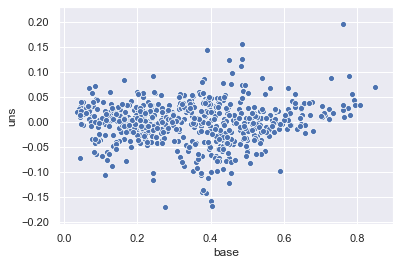

In [7]:
ax = sns.scatterplot(scores['base'],scores['uns'])

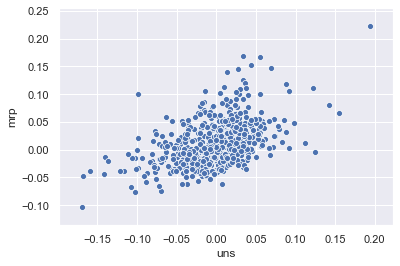

In [8]:
sns.scatterplot(scores['uns'],scores['mrp'])

In [9]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,election_results[compare_year])

## Select demographic data to compare constituencies

In [10]:
census = read_in_census()
# only want rows we have election data for
census = census.loc[election_results[year].index]

In [11]:
features = ['c11PopulationDensity',
            'c11HouseOwned',
            'c11CarsNone',
            'c11EthnicityWhite',
            'c11Unemployed',
            'c11Retired',
            'c11FulltimeStudent',
            'c11Age65to74',
            'c11DeprivedNone']

In [12]:
demographic_data = census[features]

In [13]:
# only want constituencies we have complete data for
demographic_data = demographic_data.dropna()
# Speaker seats have incomplete voting data
speaker_seats = census.index[census['constituency_name'].isin(['Chorley', 'Buckingham'])]
demographic_data = demographic_data.drop(speaker_seats)

loss = set(census.index) - set(demographic_data.index)
print('Loss =',len(loss))

Loss = 79


In [14]:
# Make some lookup containers
constits_id = demographic_data.index
constits_name = list(census.loc[constits_id]['constituency_name'])
id_to_name = {id_:name for id_,name in zip(constits_id, constits_name)}
name_to_id = {name:id_ for id_,name in zip(constits_id, constits_name)}
id_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
name_to_index = {name:i for i,name in enumerate(constits_name)}

scores = scores.loc[constits_id] # only interested in these constits now

We can now see the spread of constituencies based on their demographics.

The graph below shows contituencies close to similar constituencies. Do not read too much into the axes. Points are coloured by their labour swing relative to the national labour swing.

In [48]:
#name_to_id

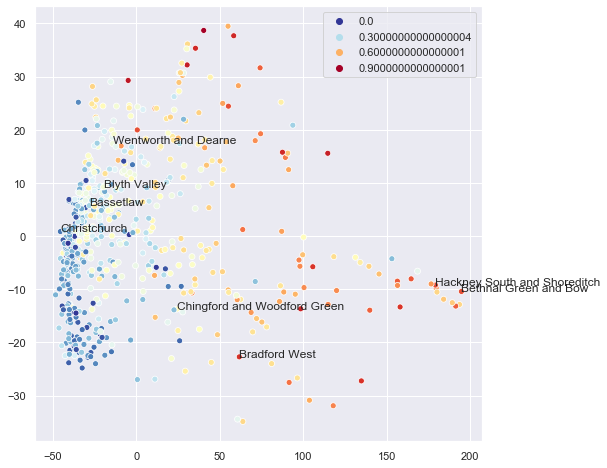

In [52]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

X_transformed = embedding.fit_transform(demographic_data)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

plt.figure(figsize=(8,8))
#hues = list(scores['uns']-0.079)
hues = list(scores['base'])
ax = sns.scatterplot(x=x,y=y,hue=hues, palette='RdYlBu_r')

for constit in ['Bethnal Green and Bow', 'Hackney South and Shoreditch','Christchurch',
                'Bradford West','Bassetlaw','Wentworth and Dearne','Blyth Valley','Chingford and Woodford Green']:
    ax.text(x[name_to_index[constit]], 
            y[name_to_index[constit]],
            constit)